In [1]:
from lake_model_outputspace_exploration import lake_problem

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    Policy,
    SequentialEvaluator
)

from ema_workbench.em_framework.output_space_exploration import OutputSpaceExploration

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [
    RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)
]

# specify outcomes
# TODO kind argument can be ignored when doing
# output space exploration

lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]

# generate some random policies by sampling over levers
n_scenarios = 1000
reference = Policy('nopolicy', **{l.name:0.02 for l in lake_model.levers})



# outputspace exploration

In [17]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergence_metrics = [
    EpsilonProgress(),
]

class Wrapper:
    # bit of a hack to get access to the inner state of the algorithm
    def __call__(self, problem, **kwargs):
        self.algorithm = OutputSpaceExploration(problem, **kwargs)
        return self.algorithm
wrapper = Wrapper()

with MultiprocessingEvaluator(lake_model) as evaluator:
    res, convergence = evaluator.optimize(algorithm=wrapper,
                             grid_spec=[(0, 12, 0.5),
                                        (0, 1, 0.1),
                                        (0, 1, 0.1),
                                        (0, 1, 0.1)],
                             nfe=50000,
                             searchover='uncertainties',
                             reference=reference,
                             convergence=convergence_metrics,
                                         )
    ose_experiments = res.iloc[:, :5].copy()
    ose_outcomes = res.iloc[:, 5::].copy()


[MainProcess/INFO] pool started with 10 workers
50063it [03:09, 263.75it/s]                                                    
[MainProcess/INFO] optimization completed, found 810 solutions
[MainProcess/INFO] terminating pool


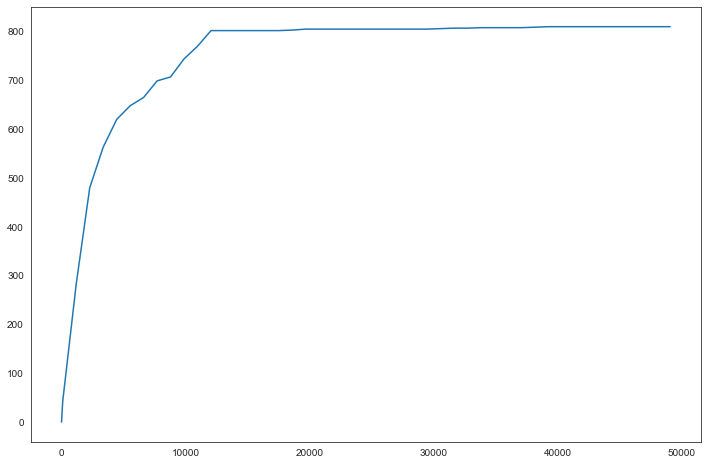

In [18]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

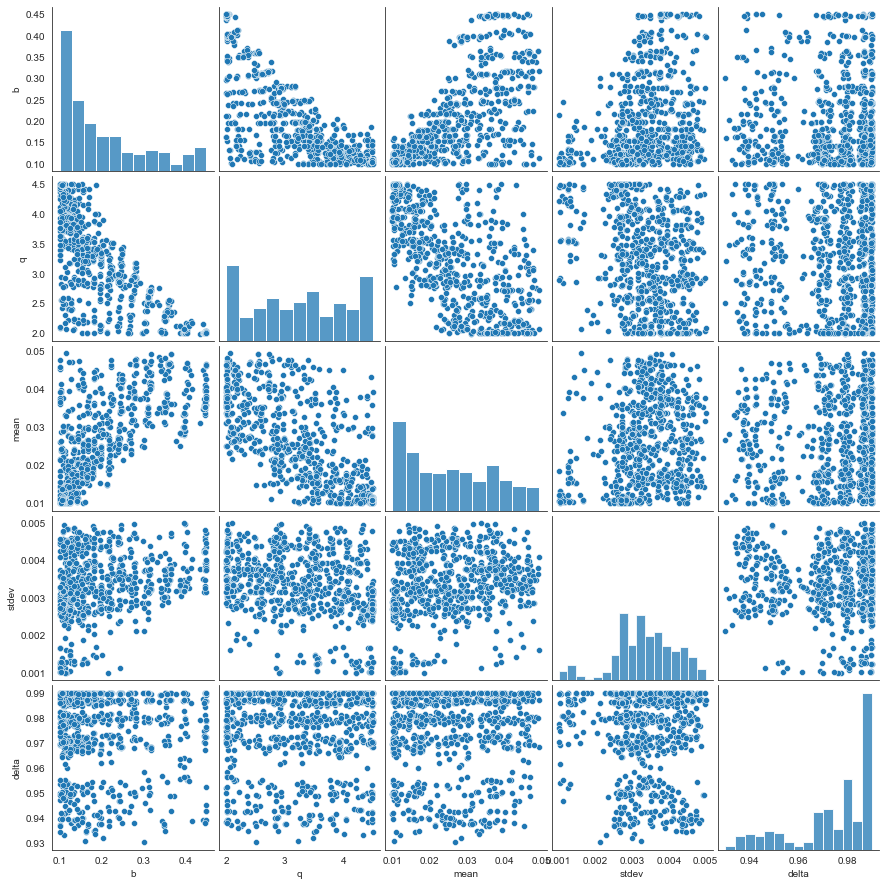

In [19]:
sns.set_style('white')
sns.pairplot(ose_experiments)
plt.show()

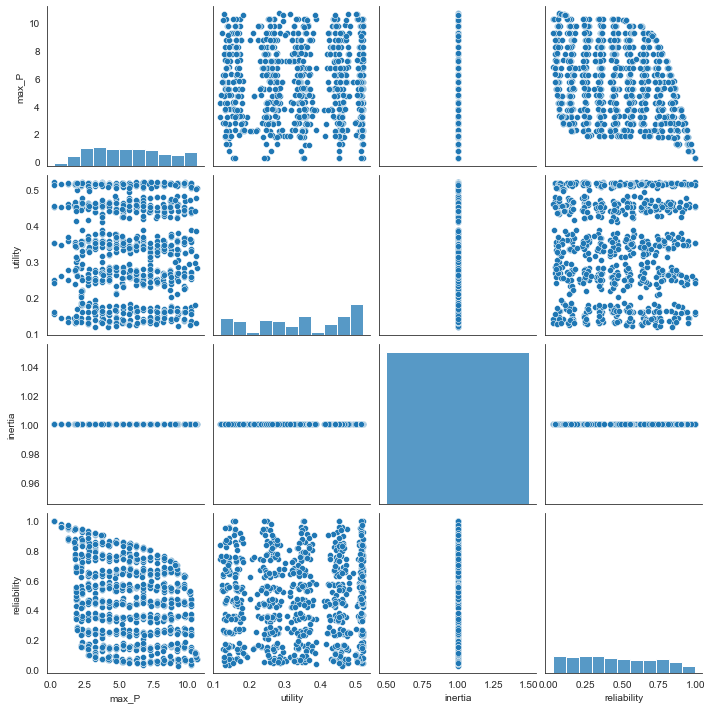

In [20]:
sns.pairplot(ose_outcomes)
plt.show()

# LHS

In [11]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
                             scenarios=1000,
                             policies=reference)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:03<00:00, 294.31it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# comparison

In [12]:
outcomes = pd.DataFrame(outcomes)
outcomes['sampling'] = 'LHS'

In [13]:
ose = res.iloc[:, 5::].copy()
ose['sampling'] = 'OSE'

In [14]:
data = pd.concat([ose, outcomes], axis=0,ignore_index=True)

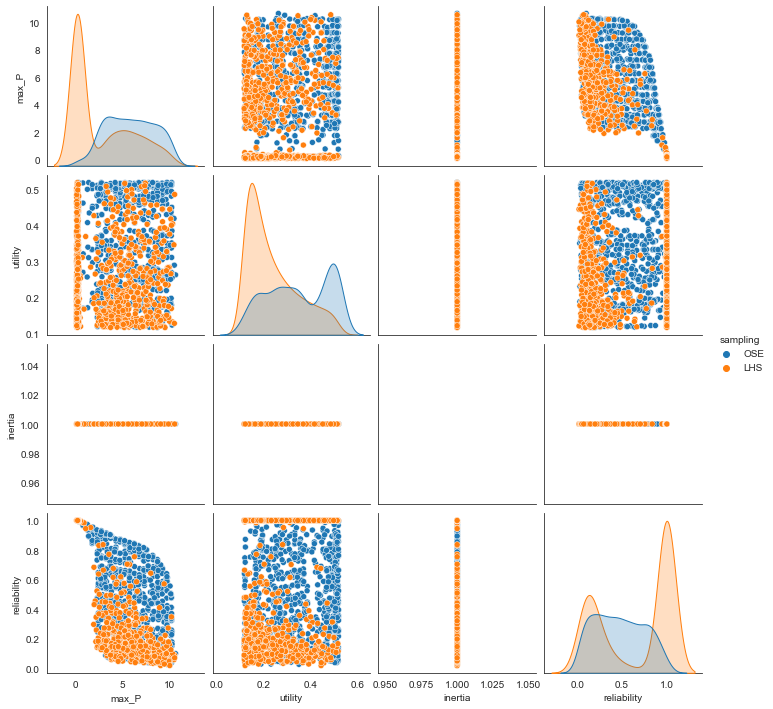

In [15]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(data, hue='sampling', vars=data.columns[0:4])
plt.show()

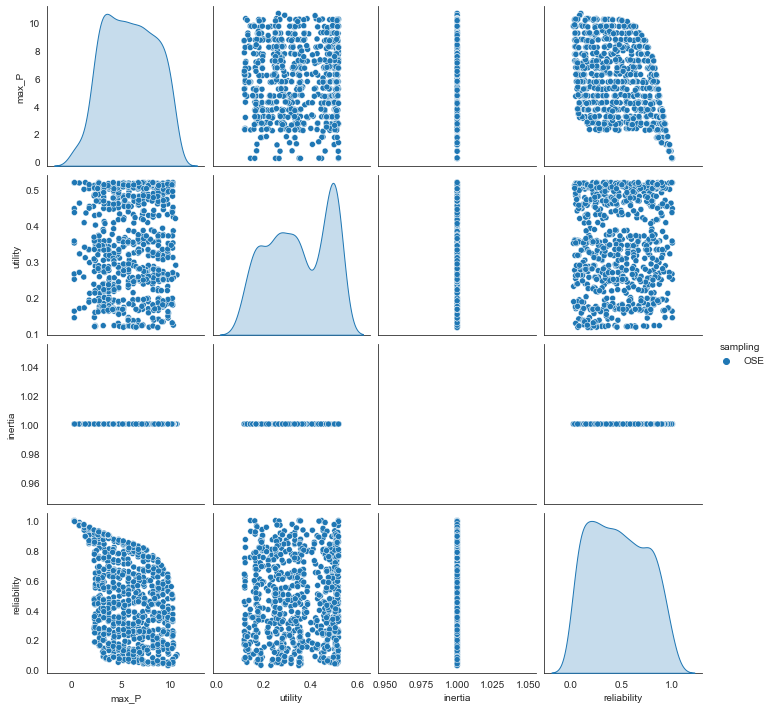

In [16]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(ose, hue='sampling', vars=data.columns[0:4])
plt.show()